# Overview

# Busines Problem

# Data Understanding

# Data Preparation

## Cleaning

In [44]:
#importing relevant libraries

import os
import pandas as pd 
import numpy as np

In [ ]:
#Turn data folder into list of data file names

data_path = os.path.join('data','zippedData')
data_files = os.listdir(data_path)
data_files.pop(data_files.index('.ipynb_checkpoints'))
data_files.pop(data_files.index('Untitled.ipynb'))
data_files = [os.path.join(data_path,file) for file in data_files]
data_files

In [ ]:
#Turn all data files into pandas dataframes

data = {}
name_dict={'imdb.title.crew.csv.gz':"crew",
           'tmdb.movies.csv.gz':"movies",
           'imdb.title.akas.csv.gz':"akas",
           'imdb.title.ratings.csv.gz':"ratings",
           'imdb.name.basics.csv.gz':"name_basics",
           'rt.reviews.tsv.gz':"reviews",
           'imdb.title.basics.csv.gz':"title_basics",
           'rt.movie_info.tsv.gz':"movie_info",
           'tn.movie_budgets.csv.gz':"movie_budgets",
           'bom.movie_gross.csv.gz':"movie_gross",
           'imdb.title.principals.csv.gz':"principals"
          }
for file in data_files:
    try:
        df = pd.read_csv(file)
    except:
        print(file)
        continue
    file_name = file.split('/')[-1]
    data[name_dict[file_name]] = df
    
data["movie_info"]=pd.read_csv('data/zippedData/rt.movie_info.tsv.gz', sep="\t")
data["reviews"]=pd.read_csv('data/zippedData/rt.reviews.tsv.gz', sep="\t", encoding="latin1")

In [ ]:
#Renaming columns to be able to merge on 'title' column

data['title_basics'] = data['title_basics'].rename(columns={'primary_title':'title'})
data['movie_budgets'] = data['movie_budgets'].rename(columns={'movie':'title'})

In [ ]:
#Getting rid of commas and dollar signs to make dataframe values easier to work with 

data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace(',', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace('$', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].astype(int)

data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace(',', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace('$', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].astype(int)

data['movie_budgets']['domestic_gross'] = data['movie_budgets']['domestic_gross'].str.replace(',', '')
data['movie_budgets']['domestic_gross'] = data['movie_budgets']['domestic_gross'].str.replace('$', '')
data['movie_budgets']['domestic_gross'] = data['movie_budgets']['domestic_gross'].astype(int)

In [ ]:
#Dropping unecessary columns

data['movie_budgets'] = data['movie_budgets'].drop(columns=['release_date','domestic_gross'])

In [ ]:
#Filter ratings dataframe to a minimum of 100 votes

data['ratings'] = data['ratings'][data['ratings'].numvotes >= 100]

In [ ]:
#Renaming more columns *****Add this to other renaming cell

data['akas'].rename(columns={'title_id': 'tconst'}, inplace = True)

In [ ]:
#Merging data on tconst

tconst_to_title = pd.merge(data['akas'],data['ratings'],on='tconst')

In [ ]:
#Dropping uncessary columns from tconst_to_title dataframe

tconst_to_title = tconst_to_title.drop(columns=['ordering','region','language','types','attributes','is_original_title'])

In [ ]:
#Merging tconst_to_title dataframe with movie_budgets dataframe on 'title' column

master_table = pd.merge(tconst_to_title,data['movie_budgets'],on='title')

In [ ]:
#Defining 'Composite Quality Score' to help define successful movies

master_table['success_score'] = master_table.averagerating * (master_table.worldwide_gross / master_table.production_budget)

In [ ]:
#Dropping duplicates from 'tconst' column in master_table dataframe

master_table.drop_duplicates(subset = ['tconst'],inplace=True)

In [ ]:
#Merging title_basics dataframe to master_table dataframe on tconst

master_table = pd.merge(data['title_basics'],master_table,on='tconst')

In [ ]:
#Making genre dataframe with individualized genres 

gml=list(master_table["genres"].unique())
genre_list=[]
for genres in gml:
    genre_list.append(genres.split(","))
genre_list
genre_master=[]
for genre in genre_list:
    for subgenre in genre:
        genre_master.append(subgenre)
unique_genre_master=set(genre_master)
vector=list(range(0,2521))
df_genres=[]
df_consts=[]
for genre in unique_genre_master:
    for number in vector:
        if genre in master_table.iloc[number, 5]:
            df_genres.append(genre)
            df_consts.append(master_table.iloc[number, 0])
genre_table=pd.DataFrame({'tconst':df_consts, 'genre':df_genres})
complete_genre_table=pd.merge(genre_table, master_table, how="left", on="tconst")

In [ ]:
#Merging movie_info dataframe with master_table dataframe

master_table = pd.merge(master_table, data['movie_info'],on='id')

In [34]:
#Creating df_composer dataframe 

df_composer = data['name_basics'].dropna(subset=['primary_profession','known_for_titles'])
df_composer["title_length"]=df_composer["known_for_titles"].map(lambda x: x.count(',') + 1)
df_composer = df_composer[df_composer.primary_profession.str.contains('composer')]

data/zippedData/rt.reviews.tsv.gz
data/zippedData/rt.movie_info.tsv.gz


/Users/MichaelWirtz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
#sorting for most popular composers

df_composer.sort_values(by='title_length',ascending=False, inplace=True)

In [51]:
#Making composer dataframe by making tconst individualized *****CHANGE NAMES TO REFLECT DIFFERENCE FROM GENRE

gml=list(df_composer["known_for_titles"][:32])
genre_list=[]
for genres in gml:
    genre_list.append(list(genres.split(",")))
genre_list
genre_master=[]
genre_master=[]
for genre in genre_list:
    for subgenre in genre:
        genre_master.append(subgenre)
        
unique_genre_master=set(genre_master)
vector=list(range(0,46984))
df_genres=[]
df_consts=[]

for genre in unique_genre_master:
    for number in vector:
        if genre in df_composer.iloc[number, 5]:
            df_genres.append(genre)
            df_consts.append(df_composer.iloc[number, 1])
            
genre_table=pd.DataFrame({'composer':df_consts, 'tconst':df_genres})

genre_table

,composer,tconst
0,Neil Cleary,tt2141589
1,Maria Vatenina,tt1362476
2,Thomas E. Brown,tt0874426
3,Ross Power,tt0874426
4,Nazareno Andorno,tt2365730
...,...,...
199,James Griffiths,tt5171438
200,Jeff Russo,tt5171438
201,Matt Decker,tt5171438
202,Todd Maki,tt1315963


In [52]:
#Merging master with composer table

master_composer = pd.merge(master_table,genre_table, on='tconst')



In [53]:
#Removing weird no values from graph

master_composer = master_composer[master_composer.composer != 'Matthew Emerson Brown']
master_composer = master_composer[master_composer.composer != 'Joshua Morrison']
master_composer = master_composer[master_composer.composer != 'Jeramy Koepping']

## Merging

## Feature Engineering

# Analysis

In [29]:
#Importing relevant libraries

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

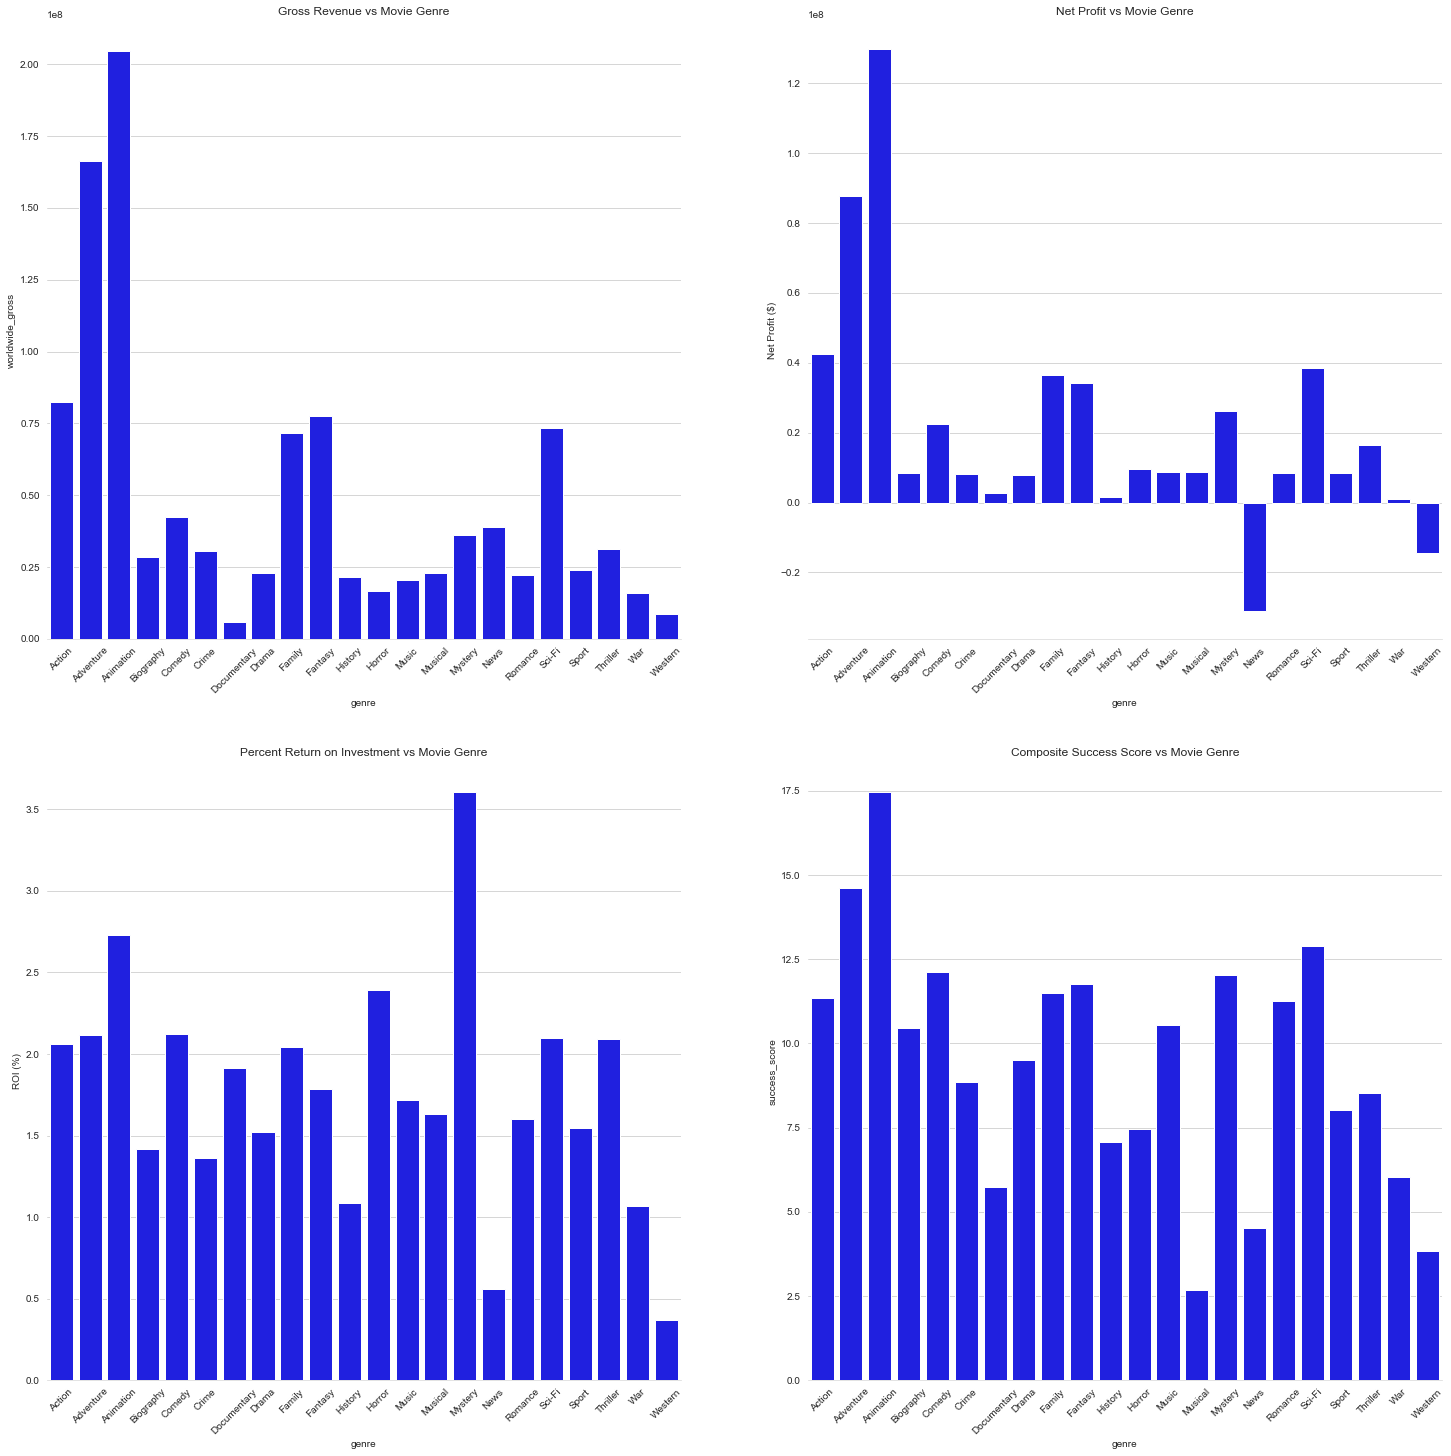

In [56]:
#Graphing Genre vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(25, 25))
x=complete_genre_table.groupby("genre").median().index
y0_gross_rev= complete_genre_table.groupby("genre").median().worldwide_gross
y1_net_prof= complete_genre_table.groupby("genre").median().worldwide_gross-complete_genre_table.groupby("genre").median().production_budget
y2_roi_percent= complete_genre_table.groupby("genre").median().worldwide_gross/complete_genre_table.groupby("genre").median().production_budget
y3_comp= complete_genre_table.groupby("genre").median().success_score

ax[0][0].set_title('Gross Revenue vs Movie Genre')
ax[0][0].set_xlabel('Movie Genre')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Movie Genre')
ax[0][1].set_xlabel('Movie Genre')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Movie Genre')
ax[1][0].set_xlabel('Movie Genre')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Movie Genre')
ax[1][1].set_xlabel('Movie Genre')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='blue')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='blue')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='blue')
sns.barplot(x, y3_comp, ax=ax[1][1], color='blue')

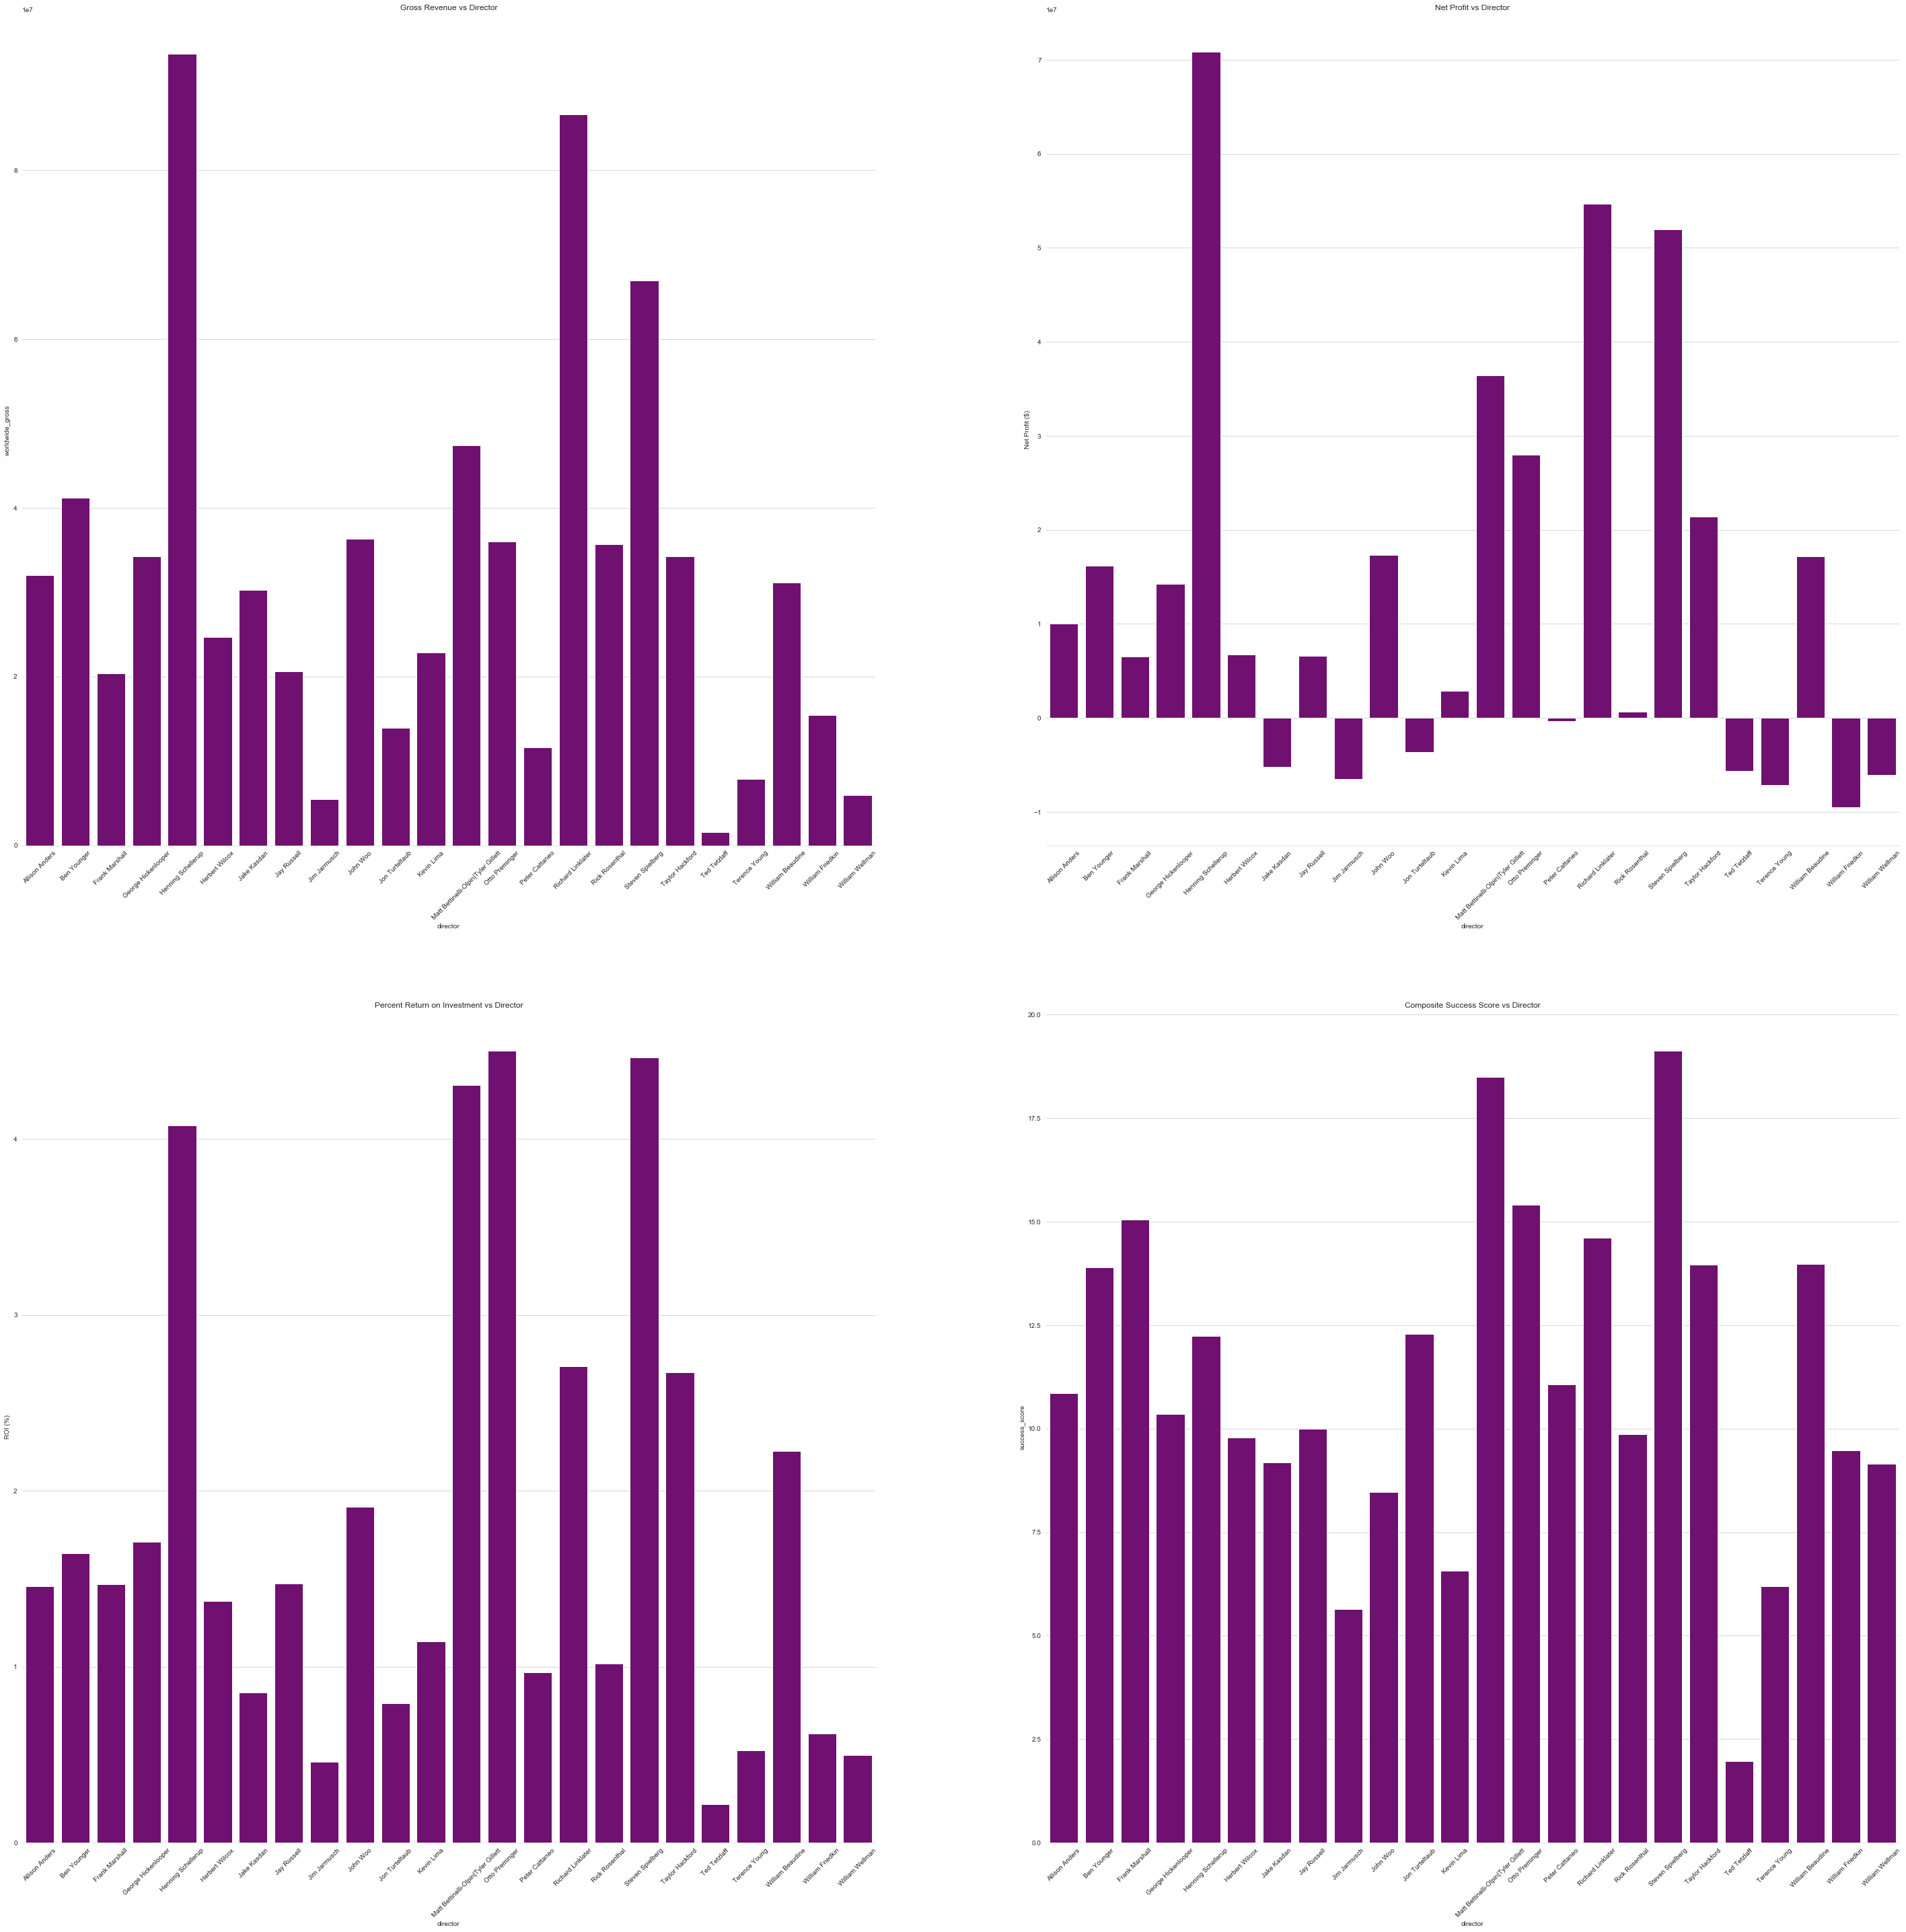

In [55]:
#Graphing Director vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_table[:750].groupby("director").median().index
y0_gross_rev= master_table[:750].groupby("director").median().worldwide_gross
y1_net_prof= master_table[:750].groupby("director").median().worldwide_gross-master_table[:750].groupby("director").median().production_budget
y2_roi_percent= master_table[:750].groupby("director").median().worldwide_gross/master_table[:750].groupby("director").median().production_budget
y3_comp= master_table[:750].groupby("director").median().success_score 
ax[0][0].set_title('Gross Revenue vs Director')
ax[0][0].set_xlabel('Director')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Director')
ax[0][1].set_xlabel('Director')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Director')
ax[1][0].set_xlabel('Director')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Director')
ax[1][1].set_xlabel('Director')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='purple')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='purple')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='purple')
sns.barplot(x, y3_comp, ax=ax[1][1], color='purple')


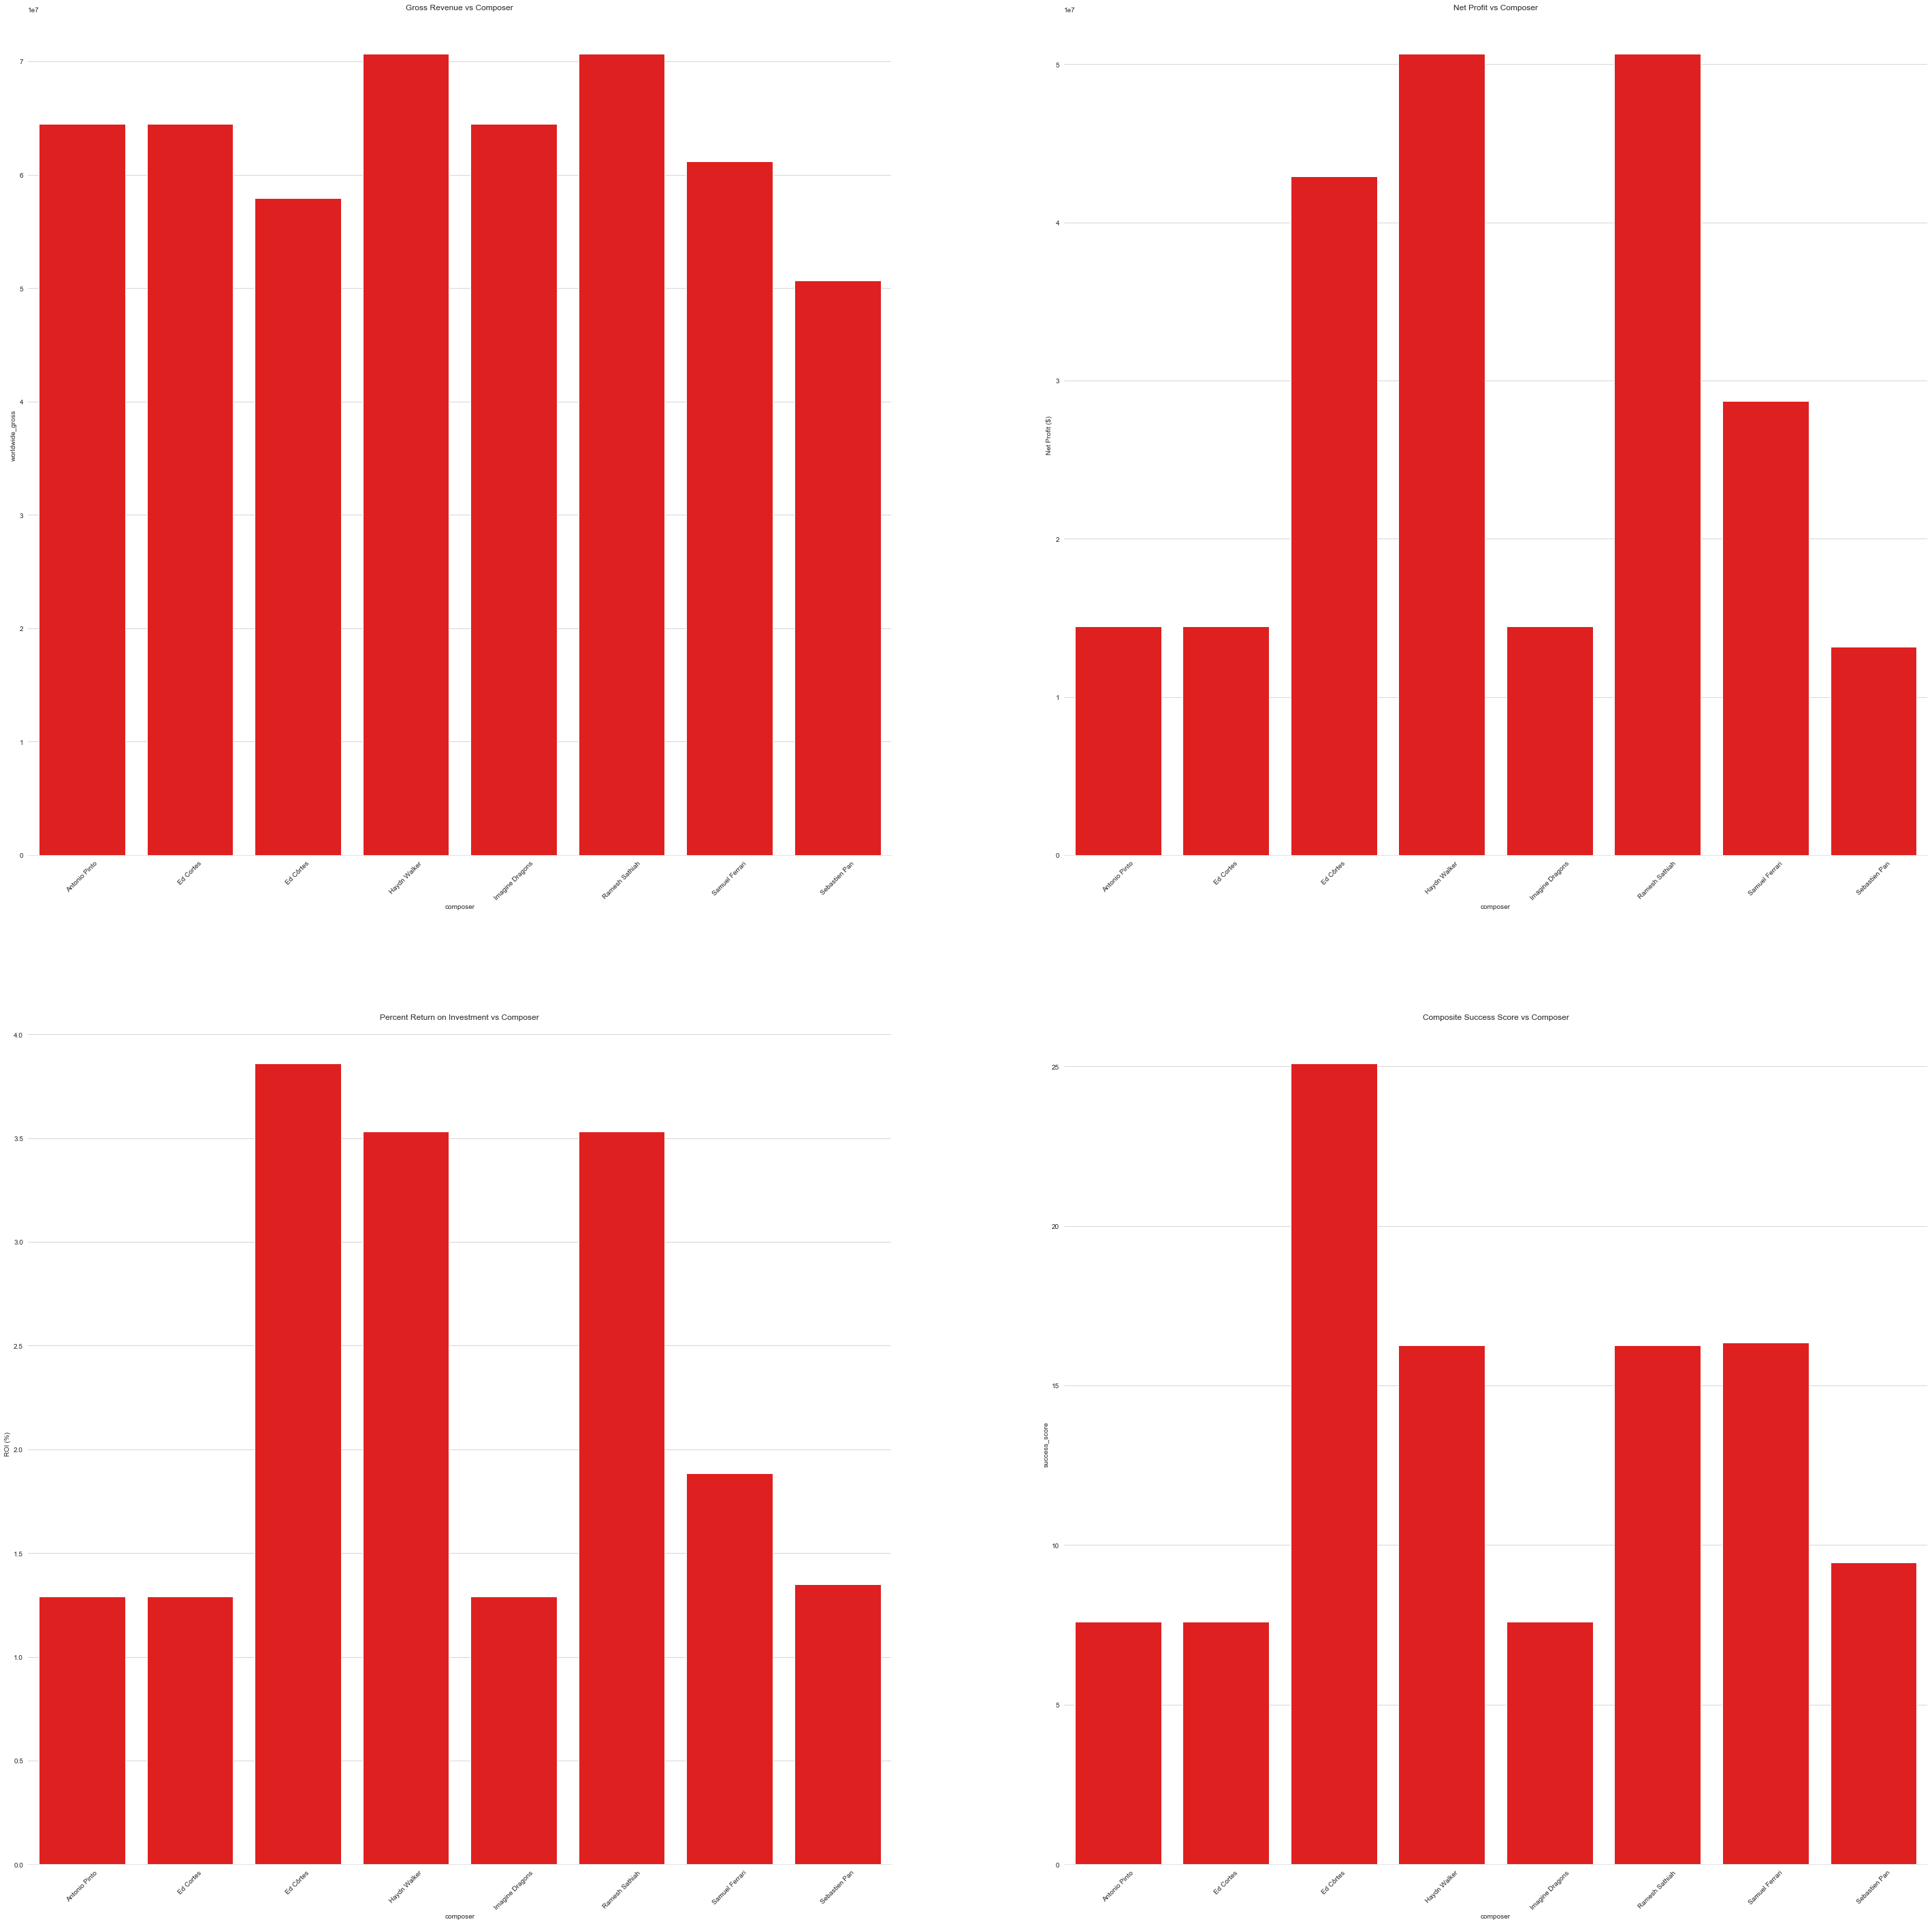

In [54]:
#Graphing Composer vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_composer.groupby("composer").median().index
y0_gross_rev= master_composer.groupby("composer").median().worldwide_gross
y1_net_prof= master_composer.groupby("composer").median().worldwide_gross-master_composer.groupby("composer").median().production_budget
y2_roi_percent= master_composer.groupby("composer").median().worldwide_gross/master_composer.groupby("composer").median().production_budget
y3_comp= master_composer.groupby("composer").median().success_score 

ax[0][0].set_title('Gross Revenue vs Composer')
ax[0][0].set_xlabel('Composer')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Composer')
ax[0][1].set_xlabel('Composer')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Composer')
ax[1][0].set_xlabel('Composer')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Composer')
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='red')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='red')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='red')
sns.barplot(x, y3_comp, ax=ax[1][1], color='red')

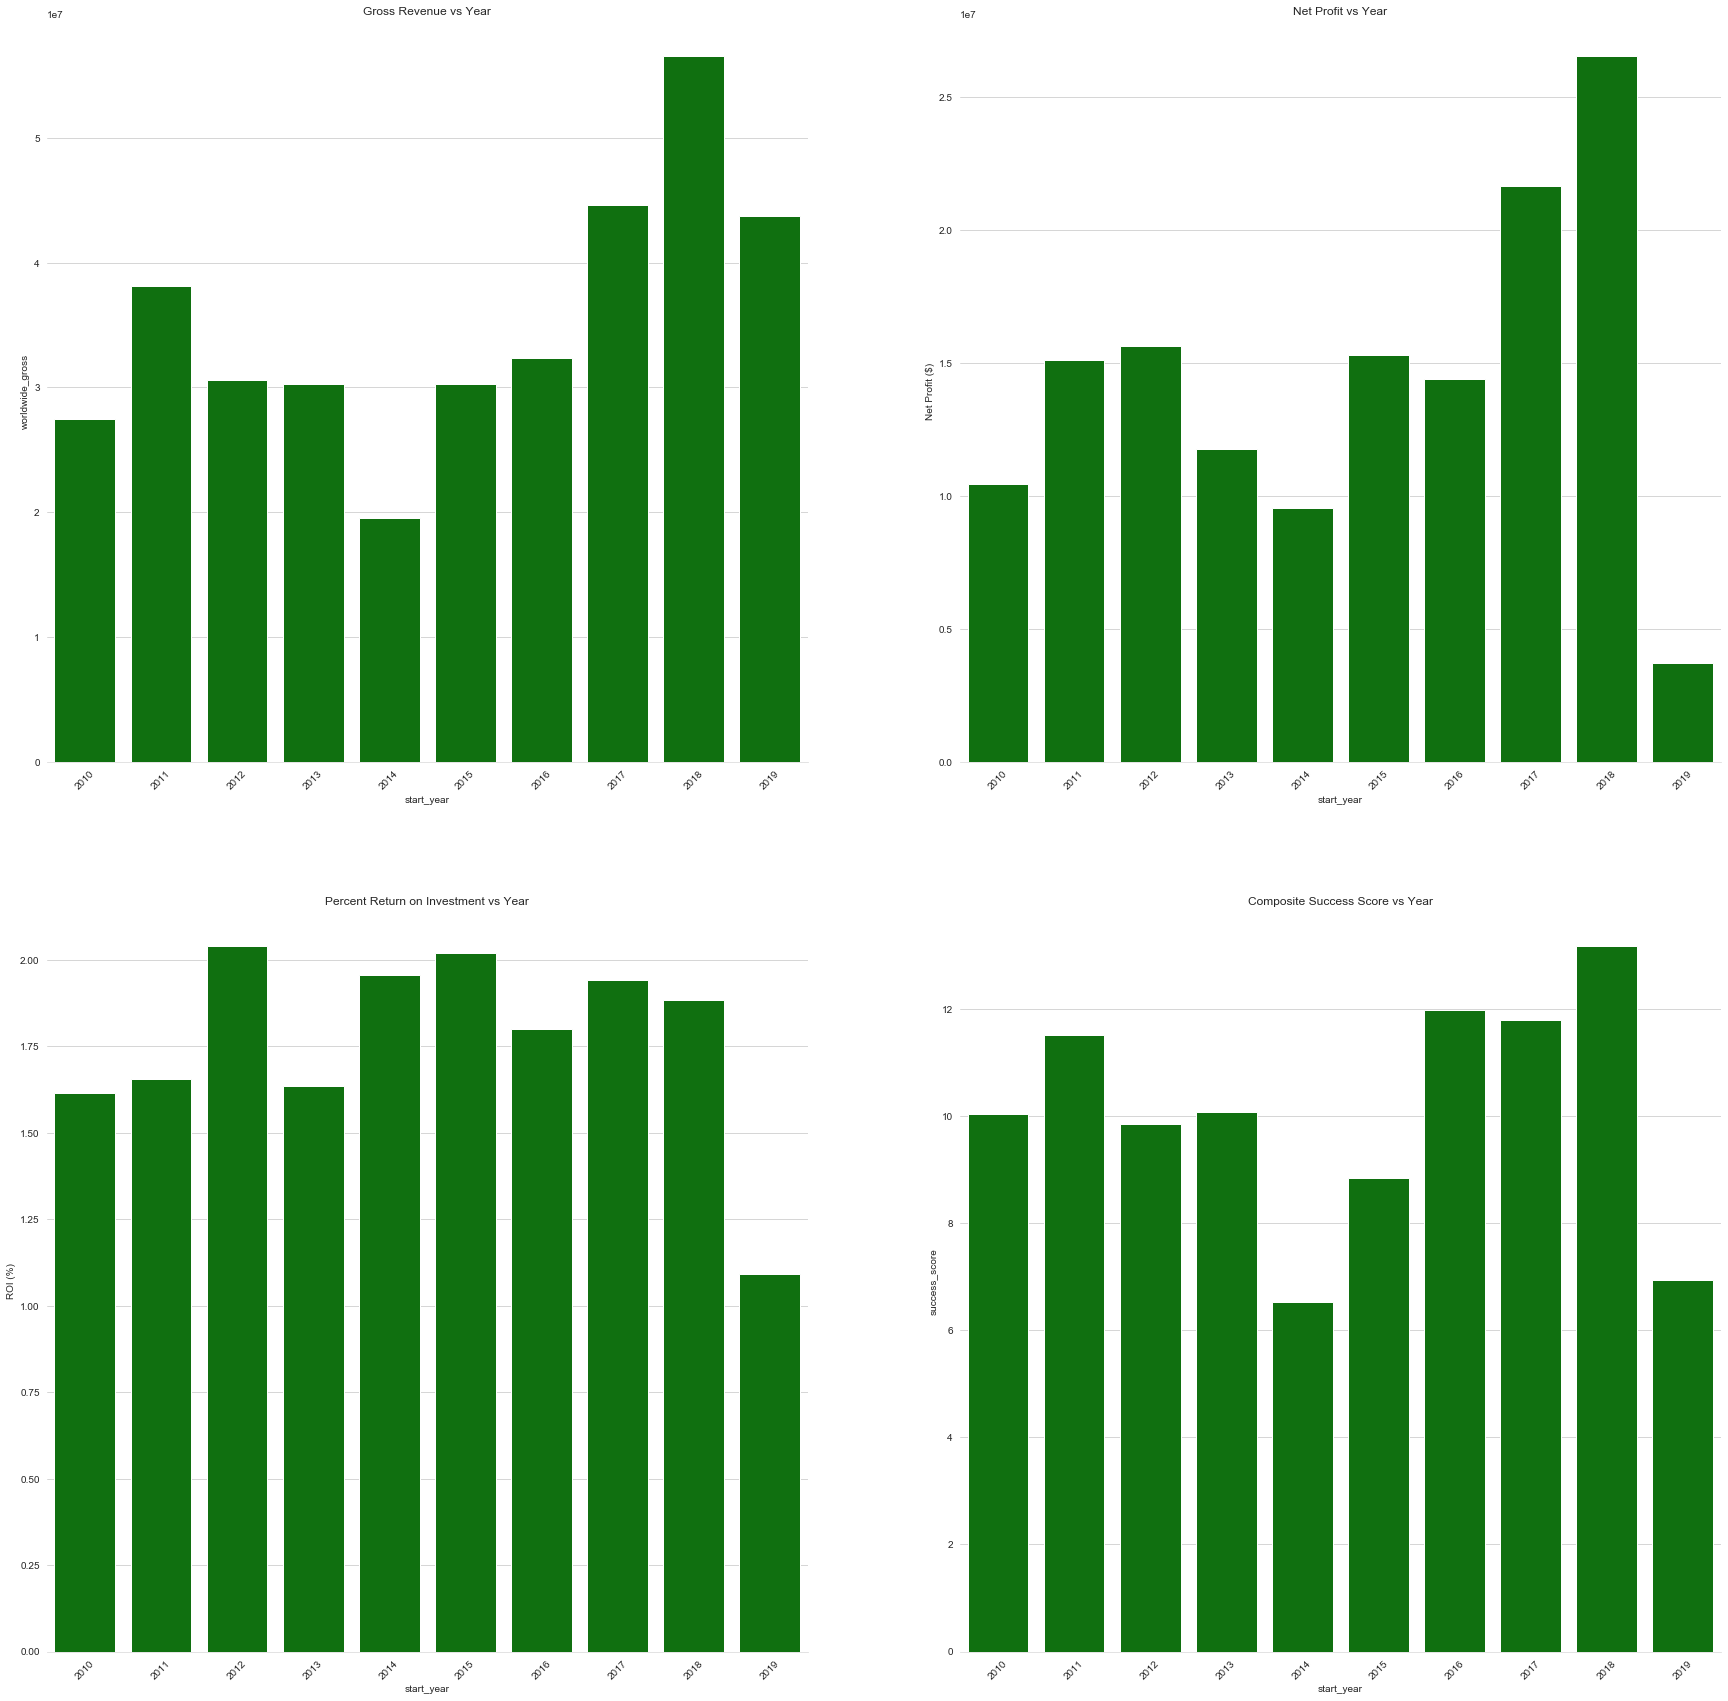

In [41]:
#Graphing Start Year vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(30, 30))
x=master_table.groupby("start_year").median().index
y0_gross_rev= master_table.groupby("start_year").median().worldwide_gross
y1_net_prof= master_table.groupby("start_year").median().worldwide_gross-master_table.groupby("start_year").median().production_budget
y2_roi_percent= master_table.groupby("start_year").median().worldwide_gross/master_table.groupby("start_year").median().production_budget
y3_comp= master_table.groupby("start_year").median().success_score 

ax[0][0].set_title('Gross Revenue vs Year')
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('Gross Revenue ($)')
ax[0][1].set_title('Net Profit vs Year')
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('Net Profit ($)')
ax[1][0].set_title('Percent Return on Investment vs Year')
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('ROI (%)')
ax[1][1].set_title('Composite Success Score vs Year')
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='green')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='green')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='green')
sns.barplot(x, y3_comp, ax=ax[1][1], color='green')

# Conclusions

## Next Steps